## Deliverable 1

Student ID's:

Andreea Roica: 20250361

Beatriz Varela: 20250367

Barbara Franco: 20250388

Marisa Esteves: 20250348

We will follow the CRISP-DM methodology.

## Business Understanding

The goal of this project is to create a regression model that can predict car prices based on its details. This includes:

- Regression Benchmarking
- Model Optimization
- Additional Insights

## Data Understanding

Metadata:

- **carID** : An attribute that contains an identifier for each car.
- **Brand** : The car’s main brand (e.g. Ford, Toyota).
- **model** : The car model.
- **year**: The year of Registration of the Car.
- **transmission** - Type of transmission of the car (e.g. Manual, Automatic, Semi-Automatic)
- **mileage** : The total reported distance travelled by the car (in miles).
- **tax** : The amount of road tax (in £) that, in 2020, was applicable to the car in question.
- **fuelType** : Type of Fuel used by the car (Diesel, Petrol, Hybrid, Electric).
- **mpg** : Average Miles per Gallon.
- **engineSize** : Size of Engine in liters (Cubic Decimeters).
- **paintQuality%** : The mechanic’s assessment of the cars’ overall paint quality and hull integrity (filled by the mechanic during evaluation).
- **previousOwners** : Number of previous registered owners of the vehicle.
- **hasDamage** : Boolean marker filled by the seller at the time of registration stating whether the car is damaged or not.
- **price** : The car’s price when purchased by Cars 4 You (in £).

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl 
from math import ceil

from sklearn.model_selection import train_test_split

# Import fuzzywuzzy to correct the typos in 'Brand', 'fuelType' snd 'transmission'
from fuzzywuzzy import fuzz

# Import get_close_matches to identify and group similar words for typo correction in 'model'
from difflib import get_close_matches

# Import to perform the Chi-squared test
from scipy.stats import chi2_contingency


In [39]:
# Set seed
np.random.seed(33)

In [40]:
#Reading the data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

### Characteristics of our data

In [41]:
df_train.head()

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0


We can already see that we have Null Values (at least in tax) and have strange values like negative previous owners

In [42]:
df_test.head()

,carID,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,89856,Hyundai,I30,2022.878006,Automatic,30700.000000,petrol,205.0,41.5,1.6,61.0,3.0,0.0
1,106581,VW,Tiguan,2017.000000,Semi-Auto,-48190.655673,Petrol,150.0,38.2,2.0,60.0,2.0,0.0
2,80886,BMW,2 Series,2016.000000,Automatic,36792.000000,Petrol,125.0,51.4,1.5,94.0,2.0,0.0
3,100174,Opel,Grandland X,2019.000000,Manual,5533.000000,Petrol,145.0,44.1,1.2,77.0,1.0,0.0
4,81376,BMW,1 Series,2019.000000,Semi-Auto,9058.000000,Diesel,150.0,51.4,2.0,45.0,4.0,0.0


In [43]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


Identified Problems:

- Year and previousOwners is float when it should be integer
- hasDamage should be boolean instead of float

In [44]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32567 entries, 0 to 32566
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           32567 non-null  int64  
 1   Brand           31918 non-null  object 
 2   model           31917 non-null  object 
 3   year            31914 non-null  float64
 4   transmission    31944 non-null  object 
 5   mileage         31878 non-null  float64
 6   fuelType        31911 non-null  object 
 7   tax             29259 non-null  float64
 8   mpg             29279 non-null  float64
 9   engineSize      31939 non-null  float64
 10  paintQuality%   31942 non-null  float64
 11  previousOwners  31970 non-null  float64
 12  hasDamage       31970 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 3.2+ MB


### Duplicates

In [45]:
print('Check duplicates:')
print(f'Train: {df_train.duplicated().sum()}\nTest: {df_test.duplicated().sum()}')
print('\nCheck duplicates in carId:')
print(f'Train: {df_train.duplicated(subset='carID').sum()}\nTest: {df_test.duplicated(subset='carID').sum()}')

Check duplicates:
Train: 0
Test: 0

Check duplicates in carId:
Train: 0
Test: 0


### Categorical Variables

In [46]:
categorical_features = ['Brand', 'model', 'transmission', 'fuelType']

In [47]:
df_train.describe(include='object')

,Brand,model,transmission,fuelType
count,74452,74456,74451,74462
unique,72,735,40,34
top,Ford,Focus,Manual,Petrol
freq,14808,6353,38050,37995


In [48]:
for feat in categorical_features:
    print(f'{feat} :' )
    print(f'{pd.concat([df_train[feat], df_test[feat]]).unique().tolist()}\n')

Brand :
['VW', 'Toyota', 'Audi', 'Ford', 'BMW', 'Skoda', 'Opel', 'Mercedes', 'FOR', 'mercedes', 'Hyundai', 'w', 'ord', 'MW', 'bmw', nan, 'yundai', 'BM', 'Toyot', 'udi', 'Ope', 'AUDI', 'V', 'opel', 'pel', 'For', 'pe', 'Mercede', 'audi', 'MERCEDES', 'OPEL', 'koda', 'FORD', 'Hyunda', 'W', 'Aud', 'vw', 'hyundai', 'skoda', 'ford', 'TOYOTA', 'ercedes', 'oyota', 'toyota', 'SKODA', 'Skod', 'HYUNDAI', 'kod', 'v', 'for', 'SKOD', 'aud', 'KODA', 'PEL', 'yunda', 'or', 'UDI', 'OYOTA', 'HYUNDA', 'mw', 'OPE', 'mercede', 'ERCEDES', 'ercede', 'TOYOT', 'MERCEDE', 'ORD', 'ud', 'ope', 'AUD', 'hyunda', 'skod', 'toyot', 'M', 'YUNDAI', 'oyot', 'bm']

model :
[' Golf', ' Yaris', ' Q2', ' FIESTA', ' 2 Series', '3 Series', ' A3', ' Octavia', ' Passat', ' Focus', ' Insignia', ' A Clas', ' Q3', ' Fabia', ' A Class', ' Ka+', ' 3 Series', ' GLC Class', ' I30', ' C Class', ' Polo', ' E Class', ' C Clas', ' Q5', ' Up', ' Fiesta', ' C-HR', ' Mokka X', ' Corsa', ' Astra', ' TT', ' 5 Series', ' Aygo', ' 4 Series', ' SLK'

**Histograms**

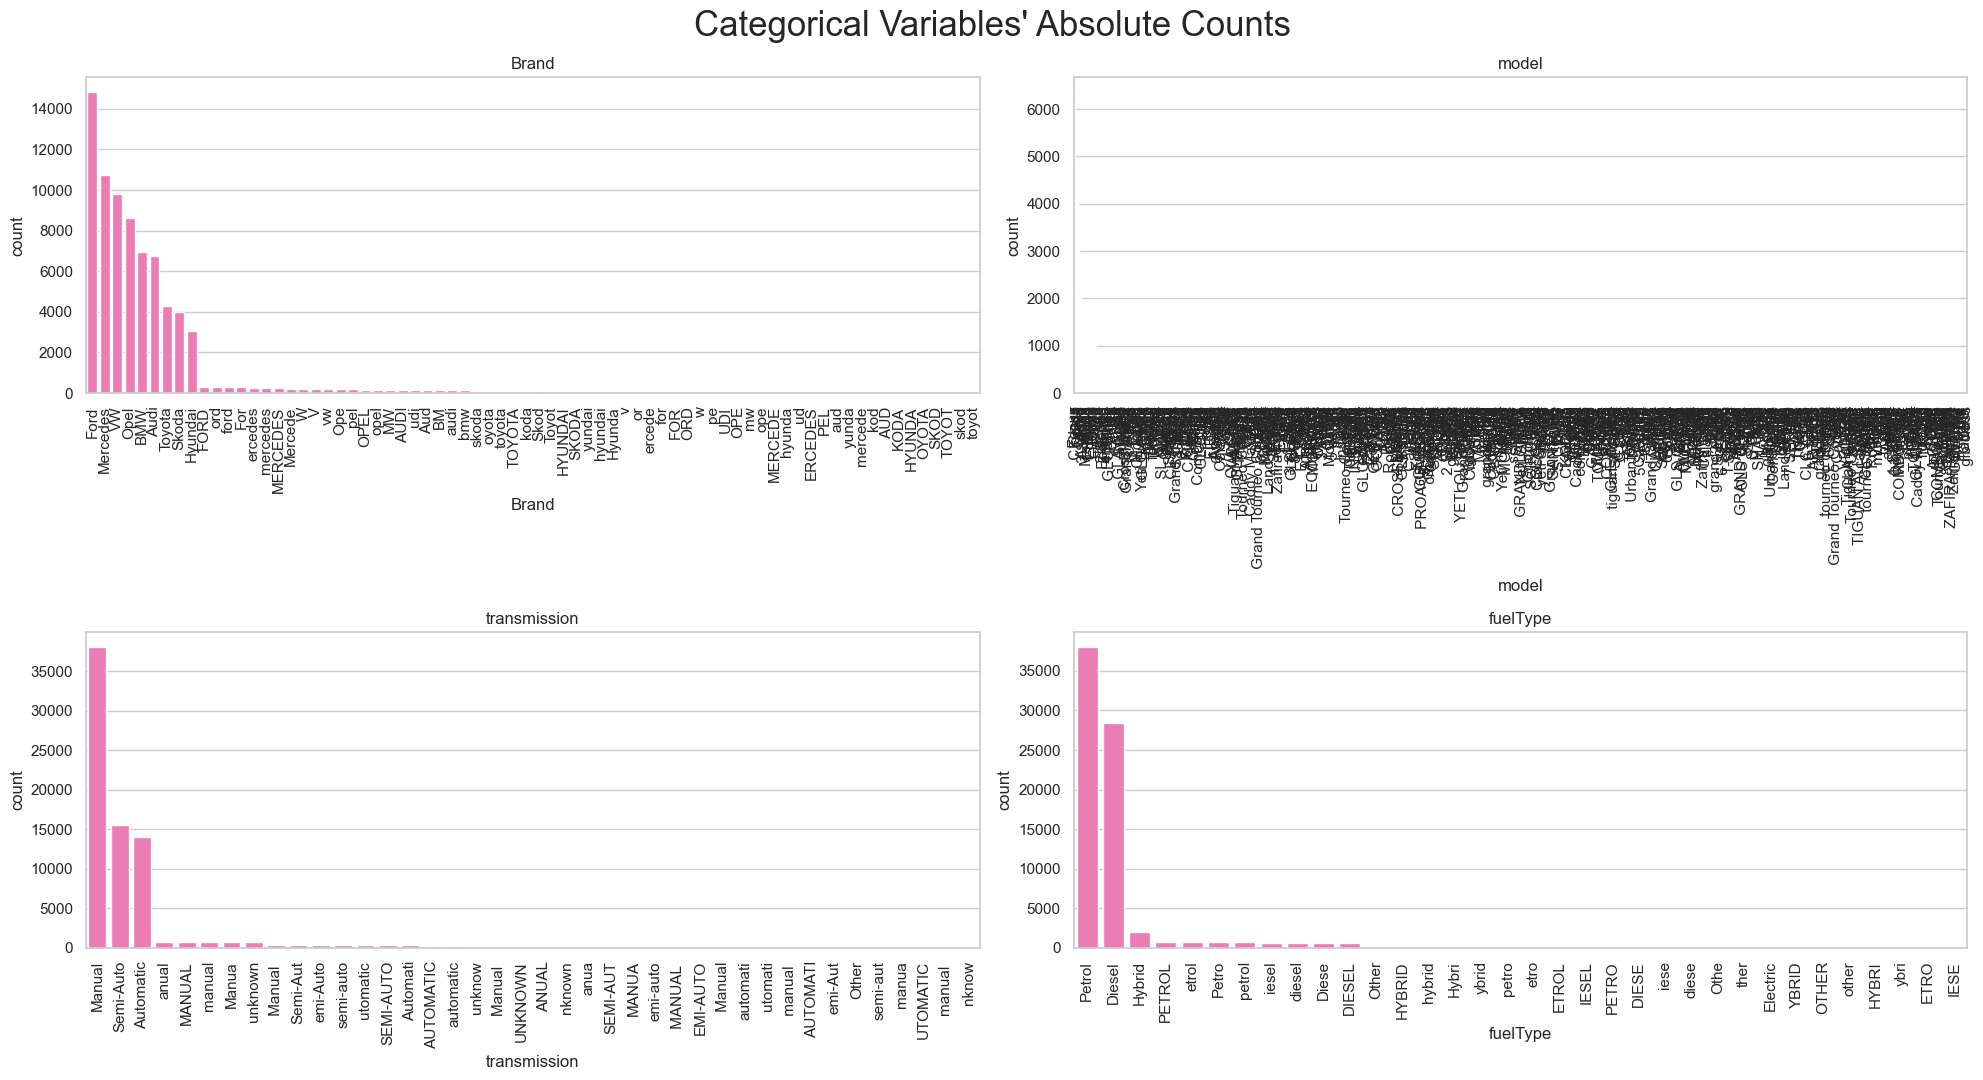

In [ ]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, ceil(len(categorical_features) / 2), figsize=(20, 11))

for ax, feat in zip(axes.flatten(), categorical_features):
    sns.countplot(x=df_train[feat], ax=ax, 
                  order=df_train[feat].value_counts().index, color = 'hotpink') 
    ax.tick_params(axis='x', rotation=90)  # roda os labels no eixo x


plt.suptitle("Categorical Variables' Absolute Counts", fontsize=25)

plt.tight_layout()
plt.show()

With these plots we can visualize the problems in the categorical variables, the huge amount of classes, most with very low frequency and simillar names. We will fix this in Data Preparation.

**Association between variables**

To evaluate the association between categorical (nominal) variables we will perfom the chi-squared test. 

H0: There is no evidence of a statistically significant association.

H1: There is a statistically significant association between the variables.

Interpretation:
- if p_value < 0.05 (significance level): Reject H0, so there is a statistically significant association between the {var1} and {var2}.
- if p_value >= 0.05 (significance level): Do not reject H0, so there is no evidence of a statistically significant association.

In [50]:
association_results = pd.DataFrame(columns=categorical_features, index=categorical_features)

def color_pvalues(val):

    #Apllies color coding to p-values.
    #Green: p-values < 0.05 (significant association).
    #Red: p-values >= 0.05 (no significant association).

    if val < 0.05:
        return 'background-color: lightgreen; color:black; border: 1px solid black;'
    else:
        return 'background-color: lightcoral; color:black; border: 1px solid black;'

for var1 in categorical_features:
    for var2 in categorical_features:
        #Chi-square test between {var1} and {var2}

        contingency_table = pd.crosstab(df_train[var1], df_train[var2]) # Create the contingency table
        result = chi2_contingency(contingency_table) # Perform the Chi-square test
                                                    #Chi-square Statistic: result[0]
                                                    #p-value: result[1]
                                                    #Degrees of Freedom: result[2]
                                                    #Expected Frequencies: result[3]
        association_results.loc[var1, var2] = result[1]

association_results= association_results.style.map(color_pvalues)
display(association_results)

,Brand,model,transmission,fuelType
Brand,0.000000,0.000000,0.000000,0.000000
model,0.000000,0.000000,0.000000,0.000000
transmission,0.000000,0.000000,0.000000,0.000000
fuelType,0.000000,0.000000,0.000000,0.000000


To measure their association we will use Cramer's V (suitable for nominal variables).

**Cramer's V = √(X2/N) / min(C-1, R-1)**

X2- Chi- squared statistics;

N- Total number of observations;

C- Number of columns in the contingency table;

R- Number of rows in the contingency table.

In [51]:
cramer_v_table = pd.DataFrame(columns=categorical_features, index = categorical_features)

for var1 in cramer_v_table.columns:
    for var2 in cramer_v_table.index:

        contingency_table = pd.crosstab(df_train[var1], df_train[var2])
        result = chi2_contingency(contingency_table)        

        # Calculate Cramer's V
        X2 = result[0]
        n = df_train.shape[0]
        minimum_dimension = min(df_train[var1].nunique(), df_train[var2].nunique())-1
        cramer_v_table.loc[var1, var2] = np.sqrt((X2/n) / minimum_dimension)

def color_cramervalues(val):
    if val > 0.6:
        return 'background-color: lightgreen; color:black; border: 1px solid black;'
    else:
        return 'background-color: lightcoral; color:black; border: 1px solid black;'


cramer_v_table= cramer_v_table.style.map(color_cramervalues)
display(cramer_v_table)

,Brand,model,transmission,fuelType
Brand,0.989939,0.338708,0.097623,0.099330
model,0.338708,0.989966,0.140960,0.192912
transmission,0.097623,0.140960,0.989933,0.071666
fuelType,0.099330,0.192912,0.071666,0.990006


The strength of the associations is low due to the number of typos that exist. 

### Numerical Variables

In [52]:
df_train = df_train.set_index ('carID')
df_test = df_test.set_index ('carID')

In [53]:
numeric_features = df_train.columns.drop(categorical_features)

In [54]:
df_train.describe()

,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
count,74482.000000,75973.000000,74510.000000,68069.000000,68047.000000,74457.000000,74449.000000,74423.000000,74425.0
mean,2017.096611,16881.889553,23004.184088,120.329078,55.152666,1.660136,64.590667,1.994580,0.0
std,2.208704,9736.926322,22129.788366,65.521176,16.497837,0.573462,21.021065,1.472981,0.0
min,1970.000000,450.000000,-58540.574478,-91.121630,-43.421768,-0.103493,1.638913,-2.345650,0.0
25%,2016.000000,10200.000000,7423.250000,125.000000,46.300000,1.200000,47.000000,1.000000,0.0
50%,2017.000000,14699.000000,17300.000000,145.000000,54.300000,1.600000,65.000000,2.000000,0.0
75%,2019.000000,20950.000000,32427.500000,145.000000,62.800000,2.000000,82.000000,3.000000,0.0
max,2024.121759,159999.000000,323000.000000,580.000000,470.800000,6.600000,125.594308,6.258371,0.0


**Histograms**

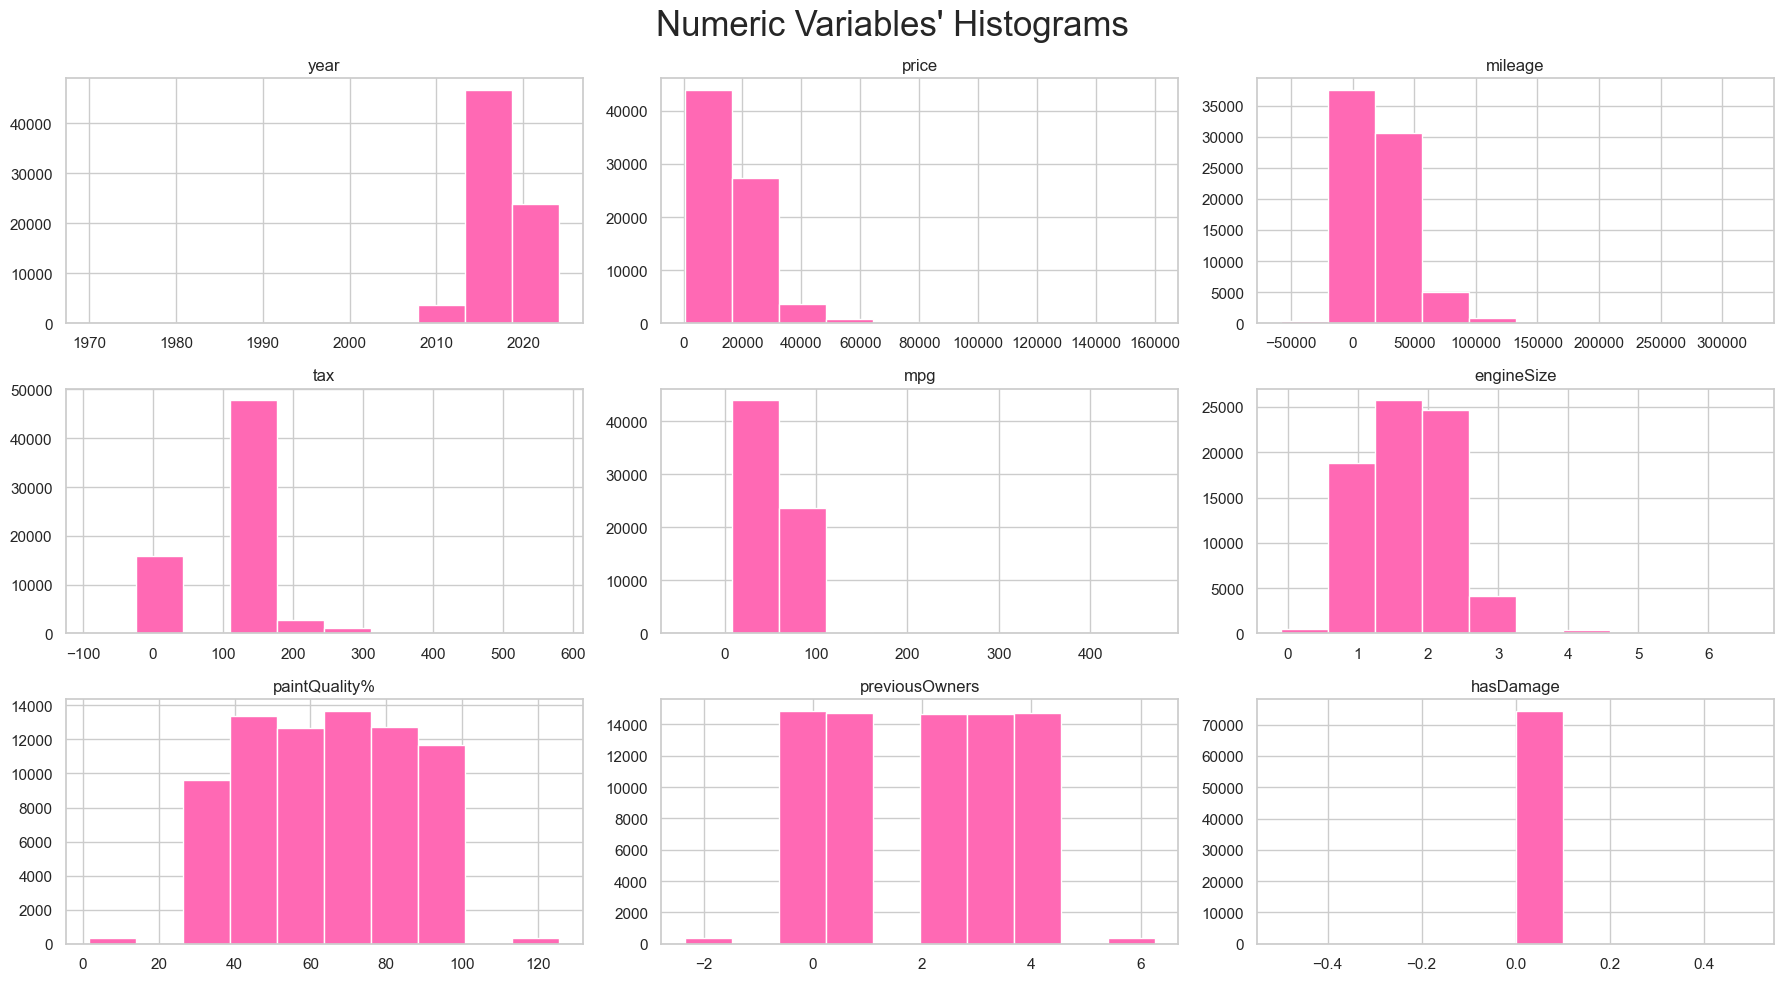

In [55]:
# We will put all the numeric variables' histograms in one figure
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(ceil(len(numeric_features) / 3 ), 3, figsize=(18, 10))

for ax, feat in zip(axes.flatten(), numeric_features):
    ax.hist(df_train[feat], color = 'hotpink')
    ax.set_title(feat)

# Delete empty plots
for ax in axes.flatten()[len(numeric_features):]:
    ax.axis('off')  

# Add a centered title to the figure:
plt.suptitle("Numeric Variables' Histograms", fontsize=25)

plt.tight_layout()
plt.show()

**Boxplots**

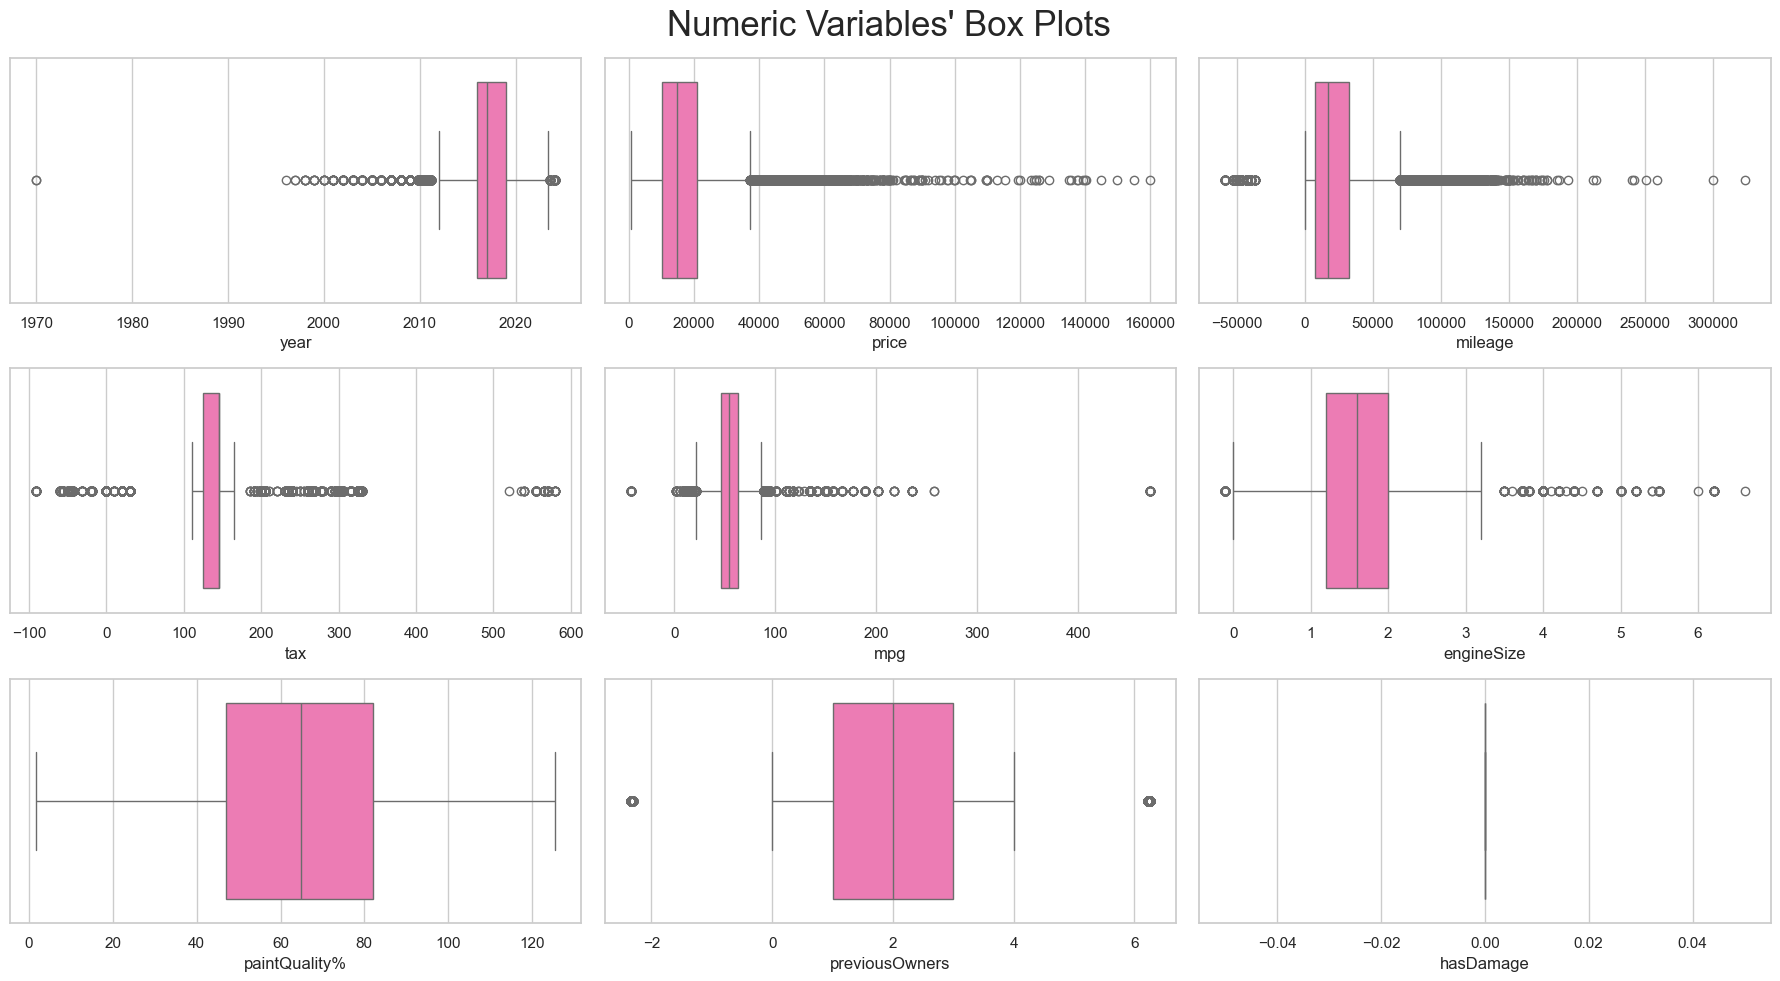

In [56]:
# We will put all the numeric variables' histograms in one figure
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(ceil(len(numeric_features) / 3 ), 3, figsize = (18,10))

for ax, feat in zip(axes.flatten(), numeric_features):
    sns.boxplot(x=df_train[feat], ax=ax, color='hotpink')

# Delete empty plots
for ax in axes.flatten()[len(numeric_features):]:
    ax.axis('off')

# Add a centered title to the figure:
plt.suptitle("Numeric Variables' Box Plots", fontsize=25)

plt.tight_layout()
plt.show()

paintQuality% and hasDamage appear to be the only features without outliers. hasDamage is a straight line only since it only has 0 ou NA.

The remaining features have a lot of outliers, and very extreme ones since the distribuition is very compressed.

**Correlations**

To measure the correlation between numerical variables we decided to use Spearman's coefficient, as it captures monotonic associations, not just linear ones. 

In [57]:
corr = df_train[numeric_features].corr(method="spearman")
corr = corr.round(2)
corr

,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
year,1.00,0.60,-0.78,0.32,-0.31,-0.04,0.00,0.00,NaN
price,0.60,1.00,-0.51,0.31,-0.39,0.56,0.00,-0.00,NaN
mileage,-0.78,-0.51,1.00,-0.25,0.32,0.10,-0.00,0.00,NaN
tax,0.32,0.31,-0.25,1.00,-0.55,0.16,0.00,-0.00,NaN
mpg,-0.31,-0.39,0.32,-0.55,1.00,-0.20,0.00,0.00,NaN
engineSize,-0.04,0.56,0.10,0.16,-0.20,1.00,0.00,0.00,NaN
paintQuality%,0.00,0.00,-0.00,0.00,0.00,0.00,1.00,-0.01,NaN
previousOwners,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.01,1.00,NaN
hasDamage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


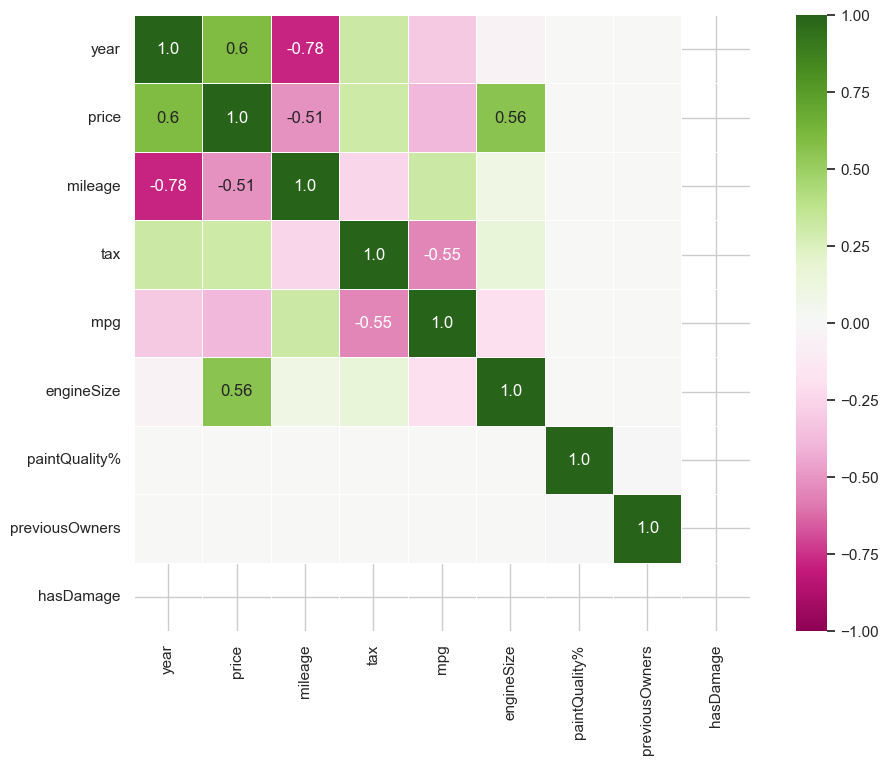

In [58]:
# Prepare figure
fig = plt.figure(figsize=(12, 8))

mask_annot = np.absolute(corr.values) >= 0.5 
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) 


# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, 
            annot=annot, # Specify custom annotation
            fmt='s', # The annotation matrix now has strings, so we need to explicitly say this
            vmin=-1, vmax=1, 
            center=0, # Center the colormap at zero
            square=True, # Make each cell square-shaped
            linewidths=.5, # Add lines between cells
            cmap='PiYG' # Diverging color map
            )

plt.show()


'previousOwners' and 'paintQuality%' present almost no correlation with the remainder, which indicates some degree of irrelevance.

'mileage' and 'year' show strong correlation (in opposite directions).

'mpg' and 'tax' show medium correlation (in opposite directions).

'mpg' and 'year', 'tax' and 'mileage', 'tax' and 'year' show medium-low correlation.

The value of the correlations is probably affected by the amount of existing errors. 

**Bivariate plots**

## Data Preparation

### Pre processing the categorical variables for practicality

In [59]:
# Pre processing the categorical variables to be easier to find clusters in typos:
    # remove spaces (at the beginning and end) and uppercase all letters
    # does not replace NaN's
df_train['Brand'] = df_train['Brand'].where(df_train['Brand'].isna(), df_train['Brand'].astype(str).str.strip().str.upper())
df_test['Brand']  = df_test['Brand'].where(df_test['Brand'].isna(), df_test['Brand'].astype(str).str.strip().str.upper())

df_train['model'] = df_train['model'].where(df_train['model'].isna(), df_train['model'].astype(str).str.strip().str.upper())
df_test['model']  = df_test['model'].where(df_test['model'].isna(), df_test['model'].astype(str).str.strip().str.upper())

df_train['fuelType'] = df_train['fuelType'].where(df_train['fuelType'].isna(), df_train['fuelType'].astype(str).str.strip().str.upper())
df_test['fuelType']  = df_test['fuelType'].where(df_test['fuelType'].isna(), df_test['fuelType'].astype(str).str.strip().str.upper())

df_train['transmission'] = df_train['transmission'].where(df_train['transmission'].isna(), df_train['transmission'].astype(str).str.strip().str.upper())
df_test['transmission']  = df_test['transmission'].where(df_test['transmission'].isna(), df_test['transmission'].astype(str).str.strip().str.upper())

### Hold Out Implementation

In [60]:
target = df_train['price']
data = df_train.drop(['price'], axis=1)

In [61]:
X_train, X_val, y_train, y_val = train_test_split(data, 
                                                 target, 
                                                 test_size=0.2, 
                                                 random_state=15, 
                                                 shuffle=True)

### Categorical Variables Treatment

##### *Brands*

In [62]:
brands = X_train['Brand'].dropna().unique().tolist()
print(f' Typos in brands: {brands}')

 Typos in brands: ['VW', 'FORD', 'HYUNDAI', 'OPEL', 'TOYOT', 'MERCEDES', 'SKODA', 'BMW', 'TOYOTA', 'AUDI', 'PEL', 'FOR', 'AUD', 'BM', 'MERCEDE', 'UDI', 'V', 'YUNDAI', 'MW', 'ORD', 'W', 'OPE', 'HYUNDA', 'KODA', 'ERCEDES', 'SKOD', 'OYOTA', 'ERCEDE', 'OR', 'PE', 'UD', 'KOD', 'YUNDA']


In Brands we have the value 'W' which could mean VW or BMW. 

In [63]:
def correct_brand_w(df, brand, model):

    '''
    The function will switch the observations 'w' and 'W' with 'BMW' and 'VW' depending on the correspondence of their
    models in other observations. This function is only applied to one element, one brand and the corresponding model

    Parameters
    -----------
    df : DataFrame
        the DataFrame whose columns are to be fixed
        
    brand : string
        the brand 

    model : string
        the corresponding model

    
    Returns
    -----------
    brand : string
        correct model, which will be 'BMW' or 'VW' if the brand is 'w' or 'W', and the input brand otherwise
    

    '''

    # If the brand in lower case is 'w' and its a string
    if isinstance(brand, str) and brand.lower() == 'w':

        # For cicle to go over the brands and corresponding models in the DataFrame
        for brand_in_column, model_in_column in zip(df['Brand'], df['model']):

            # If the same model is found, then return the corresponding brand
            if isinstance(brand_in_column, str) and model_in_column == model and brand_in_column.lower() != 'w':
                print (brand_in_column)
                return brand_in_column
            
    # If the brand is not 'w' or 'W', it remains the same           
    return brand

# Correct the 'w' and 'W' values in the columns 'Brand' by applying the function correct_brand_w to all elements in the column
X_train['Brand'] = X_train.apply(lambda row: correct_brand_w(X_train, row['Brand'], row['model']), axis = 1)

V
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
V
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
V
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
V
VW
V
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
V
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
V
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
V
VW
VW
VW
VW
VW
VW
VW
VW
VW
V
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
V
VW
V
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW


In [64]:
X_val['Brand'] = X_val.apply(lambda row: correct_brand_w(X_val, row['Brand'], row['model']), axis = 1)

VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW


In [65]:
df_test['Brand'] = df_test.apply(lambda row: correct_brand_w(df_test, row['Brand'], row['model']), axis = 1)

VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW
VW


In [66]:
print(f'Train: {X_train[(X_train['Brand']=='w') | (X_train['Brand']=='W')]}\n\n')
print(f'Validation: {X_val[(X_val['Brand']=='w') | (X_val['Brand']=='W')]}\n\n')
print(f'Test: {df_test[(df_test['Brand']=='w') | (df_test['Brand']=='W')]}')

Train:       Brand model    year transmission  mileage fuelType    tax   mpg  \
carID                                                                   
74210     W   NaN  2019.0    SEMI-AUTO   3700.0   DIESEL  145.0  52.3   
66941     W   NaN  2019.0    AUTOMATIC   6000.0      NaN  145.0  37.7   

       engineSize  paintQuality%  previousOwners  hasDamage  
carID                                                        
74210         2.0           87.0             3.0        0.0  
66941         1.5           70.0             3.0        0.0  


Validation:       Brand model    year transmission  mileage fuelType    tax   mpg  \
carID                                                                   
65456     W   NaN  2019.0       MANUAL   3000.0   DIESEL  145.0  57.7   

       engineSize  paintQuality%  previousOwners  hasDamage  
carID                                                        
65456         1.6           38.0             2.0        0.0  


Test:        Brand model    ye

We can see that we fixed the problem with the brand 'w' except for the cases with null values, which are only 5 observations. The ones that were fixed were all 'VW' so we will assume the same for these.

In [67]:
X_train.loc[X_train['Brand'] =='W' ,'Brand'] = 'VW'

X_val.loc[X_val['Brand'] =='W' ,'Brand'] = 'VW'

df_test.loc[df_test['Brand'] =='W' ,'Brand'] = 'VW'

print(X_train[X_train['Brand'] =='W'], '\n\n')
print(X_val[X_val['Brand'] =='W'], '\n\n')
print(df_test[df_test['Brand'] =='W'])


Empty DataFrame
Columns: [Brand, model, year, transmission, mileage, fuelType, tax, mpg, engineSize, paintQuality%, previousOwners, hasDamage]
Index: [] 


Empty DataFrame
Columns: [Brand, model, year, transmission, mileage, fuelType, tax, mpg, engineSize, paintQuality%, previousOwners, hasDamage]
Index: [] 


Empty DataFrame
Columns: [Brand, model, year, transmission, mileage, fuelType, tax, mpg, engineSize, paintQuality%, previousOwners, hasDamage]
Index: []


For all variables, we will follow the same logic. We will group the typos into clusters based only on the typos from the **training data**. Then, we will correct the errors in training, validation and testing based on the created clusters. If any typo has no match, it will be converted to NA and handled later.

Lets correct the typos:

TheFuzz uses the Levenshtein edit distance to calculate the degree of closeness between two strings.

**Levenshtein distance** = at a minimum, how many edits are required to change one string into the other.

In [68]:
set([len(brand) for brand in brands])

{1, 2, 3, 4, 5, 6, 7, 8}

[https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings]

[https://medium.com/@laxmi17sarki/string-matching-using-fuzzywuzzy-24be9e85c88d]

**Ratio choice**: fuzz.WRatio, most robust method

In [69]:
from fuzzywuzzy import fuzz

# Creates clusters with similar brands
def create_clusters(brand_list, column, threshold=86): #groups strings with a similarity greater than or equal to treshold%. 
    clusters = []
    for brand in brand_list:
        found = False
        for cluster in clusters:
            # evaluates if brand is similar to any cluster
            if any(fuzz.WRatio(str(brand).lower(), str(b).lower()) >= threshold for b in cluster):
                cluster.append(brand)
                found = True
                break
        #if it doesn't find a match --> new cluster
        if not found:
            clusters.append([brand])

    # Gives the clusters names- chooses the most freq name
    mapping = {}
    counts = df_train[column].value_counts()
    for cluster in clusters:
        mode = max(cluster, key=lambda x: counts.get(x,0))  #finds the "max" in the cluster according to the key --> mode
        for brand in cluster:
            mapping[brand] = str(mode.upper())

    return clusters, mapping

clusters, mapping = create_clusters(brands, 'Brand', threshold=85)

print("Clusters:")
for c in clusters:
    print(c)

X_train['Brand_cleaned'] = X_train['Brand'].map(mapping)
X_val['Brand_cleaned'] = X_val['Brand'].map(mapping)
df_test['Brand_cleaned'] = df_test['Brand'].map(mapping)

print("\nCleaned brand - Train:")
print(X_train['Brand_cleaned'].dropna().unique())

print("\nCleaned brand - Validation:")
print(X_val['Brand_cleaned'].dropna().unique())

print("\nCleaned brand - Test:")
print(df_test['Brand_cleaned'].dropna().unique())



Clusters:
['VW', 'V', 'W']
['FORD', 'FOR', 'ORD', 'OR']
['HYUNDAI', 'YUNDAI', 'HYUNDA', 'YUNDA']
['OPEL', 'PEL', 'OPE', 'PE']
['TOYOT', 'TOYOTA', 'OYOTA']
['MERCEDES', 'MERCEDE', 'ERCEDES', 'ERCEDE']
['SKODA', 'KODA', 'SKOD', 'KOD']
['BMW', 'BM', 'MW']
['AUDI', 'AUD', 'UDI', 'UD']

Cleaned brand - Train:
['VW' 'FORD' 'HYUNDAI' 'OPEL' 'TOYOTA' 'MERCEDES' 'SKODA' 'BMW' 'AUDI']

Cleaned brand - Validation:
['BMW' 'OPEL' 'AUDI' 'MERCEDES' 'FORD' 'TOYOTA' 'VW' 'HYUNDAI' 'SKODA']

Cleaned brand - Test:
['HYUNDAI' 'VW' 'BMW' 'OPEL' 'FORD' 'MERCEDES' 'SKODA' 'TOYOTA' 'AUDI']


#### *Transmission*

In [70]:
transmission_types = X_train['transmission'].dropna().unique().tolist()
print(f' Typos in models: {transmission_types}')

 Typos in models: ['MANUAL', 'SEMI-AUTO', 'AUTOMATIC', 'UNKNOWN', 'ANUAL', 'EMI-AUTO', 'MANUA', 'SEMI-AUT', 'UTOMATIC', 'AUTOMATI', 'OTHER', 'UNKNOW', 'ANUA', 'NKNOWN', 'UTOMATI', 'EMI-AUT', 'NKNOW']


In [71]:
# Creates clusters with similar fuel types
clusters, mapping = create_clusters(transmission_types, 'transmission', threshold=86)

X_train['transmission_cleaned'] = X_train['transmission'].map(mapping)
X_val['transmission_cleaned'] = X_val['transmission'].map(mapping)
df_test['transmission_cleaned'] = df_test['transmission'].map(mapping)

print("Clusters:")
for c in clusters:
    print(c)

print("\nCleaned transmission - Train:")
print(X_train['transmission_cleaned'].dropna().unique())

print("\nCleaned transmission - Validation:")
print(X_val['transmission_cleaned'].dropna().unique())

print("\nCleaned transmission - Test:")
print(df_test['transmission_cleaned'].dropna().unique())

Clusters:
['MANUAL', 'ANUAL', 'MANUA', 'ANUA']
['SEMI-AUTO', 'EMI-AUTO', 'SEMI-AUT', 'EMI-AUT']
['AUTOMATIC', 'UTOMATIC', 'AUTOMATI', 'UTOMATI']
['UNKNOWN', 'UNKNOW', 'NKNOWN', 'NKNOW']
['OTHER']

Cleaned transmission - Train:
['MANUAL' 'SEMI-AUTO' 'AUTOMATIC' 'UNKNOWN' 'OTHER']

Cleaned transmission - Validation:
['SEMI-AUTO' 'MANUAL' 'AUTOMATIC' 'UNKNOWN' 'OTHER']

Cleaned transmission - Test:
['AUTOMATIC' 'SEMI-AUTO' 'MANUAL' 'UNKNOWN' 'OTHER']


#### *Fuel Types*

In [72]:
fuel_types=X_train['fuelType'].dropna().unique().tolist()
print(f' Typos in models: {fuel_types}')

 Typos in models: ['PETROL', 'PETRO', 'DIESEL', 'HYBRID', 'DIESE', 'ETROL', 'IESEL', 'YBRID', 'OTHER', 'HYBRI', 'ETRO', 'THER', 'IESE', 'ELECTRIC', 'OTHE', 'YBRI']


In [74]:
# Creates clusters with similar fuel types
clusters, mapping = create_clusters(fuel_types, 'fuelType', threshold=85)

X_train['fuelType_cleaned'] = X_train['fuelType'].map(mapping)
X_val['fuelType_cleaned'] = X_val['fuelType'].map(mapping)
df_test['fuelType_cleaned'] =  df_test['fuelType'].map(mapping)
print("Clusters:")
for c in clusters:
    print(c)

print("\nCleaned fuel type - Train:")
print(X_train['fuelType_cleaned'].dropna().unique())

print("\nCleaned fuel type - Validation:")
print(X_val['fuelType_cleaned'].dropna().unique())

print("\nCleaned fuel type - Test:")
print(df_test['fuelType_cleaned'].dropna().unique())

Clusters:
['PETROL', 'PETRO', 'ETROL', 'ETRO']
['DIESEL', 'DIESE', 'IESEL', 'IESE']
['HYBRID', 'YBRID', 'HYBRI', 'YBRI']
['OTHER', 'THER', 'OTHE']
['ELECTRIC']

Cleaned fuel type - Train:
['PETROL' 'DIESEL' 'HYBRID' 'OTHER' 'ELECTRIC']

Cleaned fuel type - Validation:
['DIESEL' 'PETROL' 'HYBRID' 'OTHER']

Cleaned fuel type - Test:
['PETROL' 'DIESEL' 'HYBRID' 'OTHER' 'ELECTRIC']


#### *Models*

In [ ]:
models= X_train['model'].dropna().unique().tolist()
print(f'Nº of unique values: {len(models)}')

Nº of unique values: 288


In [ ]:
set([len(str(model)) for model in models])

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 21}

Fuzzywuzzy wasnt able to group the same models in the column 'model', so for this case we will use get_close_matches from difflib:

In [ ]:
def similar_models(models):

    # This list, which starts as an empty list, will store the similar groups of strings
    similar_groups = []
    
    # Start a for loop that will go over all the values in models
    for model in models:

        # Transform de list of lists in a unique list with all the values in the sublists
        similar_groups_flat = [item for sublist in similar_groups if sublist is not None for item in sublist]

        if model in similar_groups_flat:

            # If the model is already in similar_groups_flat, then it already has its similarity group, no need to serach for more
            continue
        else:
             
             # Calculate the similarity between model and the other observations and keep the ones with a similarity higher than 0.85
             close_matches = get_close_matches(model, models, cutoff=0.85)

             model_prefix =  model.split(" ")[0] 
             
             # For the models with more than one word it is necessary to evaluate the prefix in order to separate them well
             if " " in model:

                # Only keep the models with the same model code/ prefix. Different model codes belong to different models
                close_matches = [match for match in close_matches if match.split(" ")[0] == model_prefix]

            # Add the close matches to the list of similar groups
             similar_groups.append(close_matches)

    return similar_groups

clusters = similar_models (models)

print("Clusters:")
for c in clusters:
    print(c)

Clusters:
['T-ROC', 'T-RO']
['FIESTA', 'FIEST']
['GOLF', 'GOL']
['CORS', 'CORSA']
['AYG', 'AYGO']
['SLK']
['FABIA', 'FABI']
['UP']
['1 SERIES', '1 SERIE']
['KUGA', 'KUG']
['FOCU', 'FOCUS']
['TT']
['A4']
['SL CLASS', 'SL CLAS']
['4 SERIES', '4 SERIE']
['X3']
['SUPERB', 'SUPER']
['OCTAVIA', 'OCTAVI']
['C CLASS', 'C CLAS']
['A3']
['TIGUAN', 'TIGUA']
['V CLASS', 'V CLAS']
['PRIUS']
['Q5']
['GLC CLASS', 'GLC CLAS']
['MOKKA X']
['VIVA', 'VIV']
['ASTRA', 'ASTR']
['A5']
['CL CLASS']
['A1']
['ZAFIRA', 'ZAFIR']
['2 SERIES', '2 SERIE']
['POLO', 'POL']
['5 SERIES', '5 SERIE']
['AURIS', 'AURI']
['A8']
['ECOSPORT', 'ECOSPOR']
['I30']
['INSIGNIA', 'INSIGNI']
['PUMA']
['SCALA', 'SCAL']
['E CLASS', 'E CLAS']
['KA+']
['A CLASS', 'A CLAS']
['YARIS', 'YARI']
['3 SERIE', '3 SERIES']
['MOKKA', 'MOKK']
['KODIAQ', 'KODIA']
['SHUTTLE']
['Q7']
['Q3']
['GT86']
['ADAM', 'ADA']
['CROSSLAND X', 'CROSSLAND']
['GLA CLASS', 'GLA CLAS']
['RS6']
['GRAND C-MAX', 'GRAND C-MA']
['GALAXY', 'GALAX']
['KONA', 'KON']
['CITIGO'

In [ ]:
def correct_column_model(model, similar_groups):

    # If the element is NA or an empty string then nothing is changed
    if pd.isna(model) or model == ' ':
        return model
    
    # If the model has only one character then it is not possible to associate it with any model so return NA
    elif len(model) == 1:
        return np.nan
    
    # Put the model in upper case and remove spaces in beggining or end of the string
    model = model.upper().strip()

    # Go over all the sublists in similar_groups, the word similarity groups
    for group in similar_groups:

        # Find the group which contains model
        if model in group :

            # Return the match that is the longest, since it will be the complete one ( in our data set we dont have typos because of more characters, it is always beacause of less)
            return max(group, key=len) 
        
    return model

X_train['model_cleaned'] = X_train['model'].apply(lambda x: correct_column_model(x, clusters))
X_val['model_cleaned'] = X_val['model'].apply(lambda x: correct_column_model(x, clusters))
df_test['model_cleaned'] =  df_test['model'].apply(lambda x: correct_column_model(x, clusters))


In [ ]:

print("\nCleaned model - Train:")
print(X_train['model_cleaned'].dropna().unique())

print("\nCleaned model - Validation:")
print(X_val['model_cleaned'].dropna().unique())

print("\nCleaned model - Test:")
print(df_test['model_cleaned'].dropna().unique())


Cleaned model - Train:
['T-ROC' 'FIESTA' 'GOLF' 'CORSA' 'AYGO' 'SLK' 'FABIA' 'UP' '1 SERIES'
 'KUGA' 'FOCUS' 'TT' 'A4' 'SL CLASS' '4 SERIES' 'X3' 'SUPERB' 'OCTAVIA'
 'C CLASS' 'A3' 'TIGUAN' 'V CLASS' 'PRIUS' 'Q5' 'GLC CLASS' 'MOKKA X'
 'VIVA' 'ASTRA' 'A5' 'CL CLASS' 'A1' 'ZAFIRA' '2 SERIES' 'POLO' '5 SERIES'
 'AURIS' 'A8' 'ECOSPORT' 'I30' 'INSIGNIA' 'PUMA' 'SCALA' 'E CLASS' 'KA+'
 'A CLASS' 'YARIS' '3 SERIES' 'MOKKA' 'KODIAQ' 'SHUTTLE' 'Q7' 'Q3' 'GT86'
 'ADAM' 'CROSSLAND X' 'GLA CLASS' 'RS6' 'GRAND C-MAX' 'GALAXY' 'KONA'
 'CITIGO' 'I10' 'IX20' 'T-CROSS' 'X1' 'C-MAX' 'COROLLA' 'X2' 'TOUAREG'
 'GLE CLASS' 'X6' 'TUCSON' 'PASSAT' 'A6' 'M4' 'S4' 'YETI OUTDOOR'
 'GRANDLAND X' 'TOURNEO CUSTOM' 'GL CLASS' 'ARTEON' 'B CLASS' 'IX35' 'KA'
 'C-HR' 'MONDEO' 'TOURAN' 'X-CLASS' 'CLS CLASS' 'IONIQ' 'RS5' 'S CLASS'
 'HILUX' 'GLS CLASS' 'Q2' 'RAV4' 'YETI' 'KAROQ' 'S8' 'CLA CLASS' 'GOLF SV'
 'SCIROCCO' 'M CLASS' 'MERIVA' 'RAPID' 'B-MAX' 'EDGE' 'SHARAN' '7 SERIES'
 'TIGUAN ALLSPACE' 'GRAND TOURNEO CONNEC

### Numerical Variables Treatment

In [ ]:
invalid = ((X_train['year']>2020) | (X_train['mileage']<0) | (X_train['tax']<0) | 
           (X_train['mpg']<=0) | (X_train['paintQuality%']>100) | (X_train['previousOwners']< 0) | (X_train['engineSize']<= 0))


invalid_ratio = round(X_train[invalid].shape[0]/ X_train_original.shape[0] * 100,2)

print(f"Rows with invalid values account for {invalid_ratio}% of the train dataset.")

The first issues we encounter in the numerical features in the train set are:

- years above 2020 (the data base is from 2020);
- negative mileage values;
- negative tax values;
- negative/zero mpg values;
- paint quality values above 100%
- negative/zero engine size;
- previous owners with negative values;

We consider all of these values to be invalid within the context of each of these features. As the percentage of rows with at least one of these invalid values is 2.78%, we will discard them.

In [ ]:
X_train = X_train[~invalid] # discarding datapoints with invalid values
target = target[target.index.isin(X_train.index)] # discarding their targets

Year and previous owners should be whole numbers and but decimal points, so we will round them.

In [ ]:
X_train['year'] = round(X_train['year'],0)
X_train['previousOwners'] = round(X_train['previousOwners'],0)

In [ ]:
X_train[X_train['mpg'] < 15].describe()

There are two other issues:

- really low mpg values (a good standard value for cars from after the 2000s should be around 40 mpg); for example the minimum year for cars below 15 mpg in our dataset is 2008, which is not feasible.

- really small engine sizes: a minimum standard value should be 1 L;

For these reasons, we will replace mpg values below 40 and engine sizes below 1 L with missing values to be treated later.

In [ ]:
X_train.loc[X_train['mpg'] < 40, 'mpg'] = np.nan
X_train.loc[X_train['engineSize'] < 1, 'engineSize'] = np.nan

### Outlier Treatment

In [ ]:
bea

### New Visualizations

In [ ]:
bea

### Missing Values Treatment and Typecasting

NaNs will be treated as a new category.

Let's analyze the zeros vs. the NaNs to see if the NaNs are associated with damaged or undamaged cars.:


In [ ]:
cols = ['Brand_cleaned','model','fuelType_cleaned','transmission_cleaned', 'year']
distinctive_cols = [ 'price', 'mileage', 'tax', 'paintQuality%', 'previousOwners', 'hasDamage']

df_train_temp = df_train.dropna(subset=cols) [cols + distinctive_cols] 
                                            #selectes the rows with no NaN's in cols 
df_train_temp = df_train_temp [ df_train_temp.duplicated(subset=cols, keep=False) ].sort_values(cols) 
                                            #saves the filtered duplicates
groups_filtered = df_train_temp.groupby(cols).filter(lambda group: group['hasDamage'].eq(0).any() and group['hasDamage'].isna().any())
                                            #groups the rows by cols
                                            #.filter: function applied to the groups created by groupby
                                            #saves the group if there is at least one obs with 0 damamge and another with nan damage
group_dict = {name: group for name, group in groups_filtered.groupby(cols)} 

*Note*: groups_filtered.groupby(cols) is a GroupBy object. Saves the name (brand, model, etc.) of the group and the observations in each group.

In [ ]:
print(f"Number of groups: {len(group_dict)}")

In [ ]:
#Analyze the tendecy of the price, mileage, tax and paintQuality% in the groups with missing hasDamage
diffs_list = []

for name, group in group_dict.items():
    zeros = group[group['hasDamage'] == 0]
    nans = group[group['hasDamage'].isna()]

    if zeros.empty or nans.empty:
            continue

    diffs = {col: zeros[col].mean() - nans[col].mean() for col in ['price', 'mileage', 'tax', 'paintQuality%', 'previousOwners']}
    diffs_list.append(diffs)

diffs_df = pd.DataFrame(diffs_list)
    
diffs_df.median().to_frame(name='mean_diff') #median of all differences 

<div class="alert alert-block alert-danger">

We decided NaN's will be **damaged cars?**. Now lets correct the data type of the variable:

</div>

In [ ]:
#Correct data type:
df_train['hasDamage'] = df_train ['hasDamage'].astype(bool)
df_train[df_train['hasDamage'].isna()] ['hasDamage'] = True
df_test['hasDamage'] = df_test ['hasDamage'].astype(bool)
df_test[df_test['hasDamage'].isna()] ['hasDamage'] = True

In [ ]:
#Check data type:
df_train.hasDamage.dtype

#### *previousOwners*

In [ ]:
print(f'% of observations with negative owners:\nTrain:{round(df_train[df_train['previousOwners']<0].shape[0] / df_train.shape[0], 5)}\nTest:{round(df_test[df_test['previousOwners']<0].shape[0] / df_test.shape[0], 5)}')
print(f'\n% of observations with 0 owners:\nTrain:{round(df_train[df_train['previousOwners']==0].shape[0] / df_train.shape[0], 5)}\nTest:{round(df_test[df_test['previousOwners']==0].shape[0] / df_test.shape[0], 5)}')

Invalid observations - Positives vs Negatives: 

In [ ]:
neg_owners = df_train[df_train['previousOwners']<0]
pos_owners = df_train[df_train['previousOwners']>0]

In [ ]:
neg_owners.describe().T

In [ ]:
pos_owners.describe().T

Comparing the positives with the negatives:

##### Visualization

In [ ]:
df_train['OwnerStatus'] = np.where(df_train['previousOwners'] > 0, 1, 0)
    #1 if previousOwners>0 , 0 if previousOwners<=0

In [ ]:
categorical_features = ['Brand_cleaned', 'model','fuelType_cleaned', 'transmission_cleaned', 'hasDamage']
not_used=['Brand', 'transmission', 'fuelType', 'model_cleaned', 'previousOwners', 'OwnerStatus']
numeric_features = df_train.columns.drop(categorical_features + not_used)
numeric_features

In [ ]:
df_train_temp = df_train[df_train['previousOwners']!=0]

#Numeric Variables
for col in numeric_features:
    if col not in df_train.columns:
        continue
    plt.figure(figsize=(7, 4))
    df_train_temp.boxplot(column=col, by='OwnerStatus', grid=False)
    plt.title(f"{col} by OwnerStatus")
    plt.suptitle("")
    plt.xlabel("OwnerStatus (0=Negative, 1=Positive)")
    plt.ylabel(col)
    plt.xticks([1, 2], ['Negative', 'Positive'])
    plt.tight_layout()
    plt.show()

#Categorical Variables
for col in categorical_features:
    if col not in df_train.columns:
        continue
    plt.figure(figsize=(7, 4))
    pd.crosstab(df_train['OwnerStatus'], df_train[col], normalize='index').plot(
        kind='bar', stacked=True, ax=plt.gca(), colormap='tab20'
    )
    plt.title(f"Distribution of {col} by OwnerStatus")
    plt.xlabel("OwnerStatus (0=Negative, 1=Positive)")
    plt.ylabel("Proportion")
    plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

df_train.drop('OwnerStatus', axis=1, inplace=True)

<div class="alert alert-block alert-danger">

Negatives and positives exhibit similar behavior in almost all features, except for tax and engine size, where the difference is quite significant.

Therefore, the population of positives and negatives cannot be equated.

We will treat *negatives* and *zeros* as NaNs. 

</div>

#### *paintQuality%*

In [ ]:
print(f'% of observations outside of a meaningful range: {round(df_train[df_train['paintQuality%']>100].shape[0] / df_train.shape[0], 5)}')

In [ ]:
df_train [df_train ['paintQuality%']>100] ['paintQuality%'].unique()

##### Visualization

In [ ]:
df_train['PaintQualityStatus'] = np.where(df_train['paintQuality%'] <= 100, 1, 0)
    #1 if paintQuality%<=100 , 0 if paintQuality%>100

In [ ]:
categorical_features = ['Brand_cleaned', 'model','fuelType_cleaned', 'transmission_cleaned', 'hasDamage']
not_used=['Brand', 'transmission', 'fuelType', 'model_cleaned', 'paintQuality%', 'PaintQualityStatus']
numeric_features = df_train.columns.drop(categorical_features + not_used)

In [ ]:
#Numeric Variables
for col in numeric_features:
    if col not in df_train.columns:
        continue
    plt.figure(figsize=(7, 4))
    df_train.boxplot(column=col, by='PaintQualityStatus', grid=False)
    plt.title(f"{col} by PaintQualityStatus")
    plt.suptitle("")
    plt.xlabel("PaintQualityStatus (0=Not Valid, 1=Valid)")
    plt.ylabel(col)
    plt.xticks([1, 2], ['Negative', 'Positive'])
    plt.tight_layout()
    plt.show()

#Categorical Variables
for col in categorical_features:
    if col not in df_train.columns:
        continue
    plt.figure(figsize=(7, 4))
    pd.crosstab(df_train['PaintQualityStatus'], df_train[col], normalize='index').plot(
        kind='bar', stacked=True, ax=plt.gca(), colormap='tab20'
    )
    plt.title(f"Distribution of {col} by PaintQualityStatus")
    plt.xlabel("PaintQualityStatus (0=Not Valid, 1=Valid)")
    plt.ylabel("Proportion")
    plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

Looking at the box plots and histograms, there is no apparent reason for these invalid observations.

##### Let us analyze these observations in more detail: 

In [ ]:
#Average paint quality by brand
df_train.groupby('Brand_cleaned')['paintQuality%'].mean().sort_values(ascending=False)

No brand stands out.

In [ ]:
#Already seen in the histogram, but just to confirm.
print('Of the invalid observations, how many are in each brand (in %):\n')
print(df_train[df_train['PaintQualityStatus'] == 0]['Brand_cleaned'].value_counts(normalize=True).sort_values(ascending=False))
print('\nOf the valid observations, how many are in each brand (in %):\n')
print(df_train[df_train['PaintQualityStatus'] == 1]['Brand_cleaned'].value_counts(normalize=True).sort_values(ascending=False))

We confirm the distribution is very similar. 

Let's compare the Ford group in both data sets:

In [ ]:
df_train_temp = df_train[df_train['Brand_cleaned']=='Ford']

#Numeric Variables
for col in numeric_features:
    if col not in df_train_temp.columns:
        continue
    plt.figure(figsize=(7, 4))
    df_train_temp.boxplot(column=col, by='PaintQualityStatus', grid=False)
    plt.title(f"{col} by PaintQualityStatus - Ford Group")
    plt.suptitle("")
    plt.xlabel("PaintQualityStatus (0=Not Valid, 1=Valid)")
    plt.ylabel(col)
    plt.xticks([1, 2], ['Negative', 'Positive'])
    plt.tight_layout()
    plt.show()

#Categorical Variables
for col in categorical_features:
    if col not in df_train_temp.columns:
        continue
    plt.figure(figsize=(7, 4))
    pd.crosstab(df_train_temp['PaintQualityStatus'], df_train_temp[col], normalize='index').plot(
        kind='bar', stacked=True, ax=plt.gca(), colormap='tab20'
    )
    plt.title(f"Distribution of {col} by PaintQualityStatus- Ford Group")
    plt.xlabel("PaintQualityStatus (0=Not Valid, 1=Valid)")
    plt.ylabel("Proportion")
    plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

In [ ]:
df_train.drop('PaintQualityStatus', axis=1, inplace=True)

<div class="alert alert-block alert-danger">

I would consider the invalid observations as NaN's. 

</div>

#### *engineSize*

In [ ]:
print(f'% of negative sizes: {round(df_train[df_train['engineSize']<0].shape[0] / df_train.shape[0], 5)}')
print(f'% of size 0: {round(df_train[df_train['engineSize']==0].shape[0] / df_train.shape[0], 5)}')

Comparing the positives with the negatives:

##### Visualization

In [ ]:
df_train['EngineSizeStatus'] = np.where(df_train['engineSize'] >= 0, 1, 0)
    #1 if valid , 0 if invalid

In [ ]:
categorical_features = ['Brand_cleaned', 'model','fuelType_cleaned', 'transmission_cleaned', 'hasDamage']
not_used=['Brand', 'transmission', 'fuelType', 'model_cleaned', 'engineSize', 'EngineSizeStatus']
numeric_features = df_train.columns.drop(categorical_features + not_used)

In [ ]:
df_train_temp = df_train[df_train['engineSize']!=0]

#Numeric Variables
for col in numeric_features:
    if col not in df_train_temp.columns:
        continue
    plt.figure(figsize=(7, 4))
    df_train_temp.boxplot(column=col, by='EngineSizeStatus', grid=False)
    plt.title(f"{col} by EngineSizeStatus")
    plt.suptitle("")
    plt.xlabel("EngineSizeStatus (0=Negative, 1=Positive)")
    plt.ylabel(col)
    plt.xticks([1, 2], ['Negative', 'Positive'])
    plt.tight_layout()
    plt.show()

#Categorical Variables
for col in categorical_features:
    if col not in df_train_temp.columns:
        continue
    plt.figure(figsize=(7, 4))
    pd.crosstab(df_train_temp['EngineSizeStatus'], df_train_temp[col], normalize='index').plot(
        kind='bar', stacked=True, ax=plt.gca(), colormap='tab20'
    )
    plt.title(f"Distribution of {col} by EngineSizeStatus")
    plt.xlabel("EngineSizeStatus (0=Negative, 1=Positive)")
    plt.ylabel("Proportion")
    plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

df_train.drop('EngineSizeStatus', axis=1, inplace=True)

<div class="alert alert-block alert-danger">

The negatives and positives show similar behavior. Should we do the correspondence?

Treat the zeros as NaN's.

</div>

#### *mpg*

In [ ]:
print(f'% of negative mpg: {round(df_train[df_train['mpg']<0].shape[0] / df_train.shape[0], 5)}')
print(f'% of 0 mpg: {round(df_train[df_train['mpg']==0].shape[0] / df_train.shape[0], 5)}')

In [ ]:
print(f'% of observations outside of meaningful interval (10-70)- Train: {round(df_train[(df_train['mpg']<10) & (df_train['mpg']>70)].shape[0] / df_train.shape[0], 5)}')
print(f'% of observations outside of meaningful interval (10-70)- Test: {round(df_test[(df_test['mpg']<10) & (df_test['mpg']>70)].shape[0] / df_test.shape[0], 5)}')

<div class="alert alert-block alert-danger">

No observations outside the range [10, 70].

</div>

In [ ]:
#Change mpg of Eletrics to Unknown:
df_train.loc[df_train['fuelType']=='Electric', 'fuelType'] = 'Unknown'

Comparing the positives with the negatives:

##### Visualization:

In [ ]:
df_train['mpgStatus'] = np.where(df_train['mpg'] >= 0, 1, 0)
    #1 if valid , 0 if invalid

In [ ]:
categorical_features = ['Brand_cleaned', 'model','fuelType_cleaned', 'transmission_cleaned', 'hasDamage']
not_used=['Brand', 'transmission', 'fuelType', 'model_cleaned', 'mpg', 'mpgStatus']
numeric_features = df_train.columns.drop(categorical_features + not_used)

In [ ]:
#Numeric Variables
for col in numeric_features:
    if col not in df_train.columns:
        continue
    plt.figure(figsize=(7, 4))
    df_train.boxplot(column=col, by='mpgStatus', grid=False)
    plt.title(f"{col} by mpgStatus")
    plt.suptitle("")
    plt.xlabel("mpgStatus (0=Negative, 1=Positive)")
    plt.ylabel(col)
    plt.xticks([1, 2], ['Negative', 'Positive'])
    plt.tight_layout()
    plt.show()

#Categorical Variables
for col in categorical_features:
    if col not in df_train.columns:
        continue
    plt.figure(figsize=(7, 4))
    pd.crosstab(df_train['mpgStatus'], df_train[col], normalize='index').plot(
        kind='bar', stacked=True, ax=plt.gca(), colormap='tab20'
    )
    plt.title(f"Distribution of {col} by mpgStatus")
    plt.xlabel("mpgStatus (0=Negative, 1=Positive)")
    plt.ylabel("Proportion")
    plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

Clearly not similar. 

In [ ]:
print('Of the invalid observations, how many are in each brand (in %):\n')
print(df_train[df_train['mpgStatus'] == 0]['Brand_cleaned'].value_counts(normalize=True).sort_values(ascending=False))

Most invalid observations are concentrated in the Ford and Mercedes group.

In [ ]:
df_train_temp = df_train[df_train['Brand_cleaned']=='Ford']
#Numeric Variables
for col in numeric_features:
    if col not in df_train_temp.columns:
        continue
    plt.figure(figsize=(7, 4))
    df_train_temp.boxplot(column=col, by='mpgStatus', grid=False)
    plt.title(f"{col} by mpgStatus- Ford Group")
    plt.suptitle("")
    plt.xlabel("mpgStatus (0=Negative, 1=Positive)")
    plt.ylabel(col)
    plt.xticks([1, 2], ['Negative', 'Positive'])
    plt.tight_layout()
    plt.show()

#Categorical Variables
for col in categorical_features:
    if col not in df_train.columns:
        continue
    plt.figure(figsize=(7, 4))
    pd.crosstab(df_train_temp['mpgStatus'], df_train_temp[col], normalize='index').plot(
        kind='bar', stacked=True, ax=plt.gca(), colormap='tab20'
    )
    plt.title(f"Distribution of {col} by mpgStatus - Ford Group")
    plt.xlabel("mpgStatus (0=Negative, 1=Positive)")
    plt.ylabel("Proportion")
    plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

**FORD GROUP**

The range of years is greater for invalid observations, and their average price and mileage is slightly higher.

The invalid observations are concentrated in some specfic models--> check again after cleaning the models. 

In [ ]:
df_train_temp = df_train[df_train['Brand_cleaned']=='Mercedes']
#Numeric Variables
for col in numeric_features:
    if col not in df_train_temp.columns:
        continue
    plt.figure(figsize=(7, 4))
    df_train_temp.boxplot(column=col, by='mpgStatus', grid=False)
    plt.title(f"{col} by mpgStatus- Mercedes Group")
    plt.suptitle("")
    plt.xlabel("mpgStatus (0=Negative, 1=Positive)")
    plt.ylabel(col)
    plt.xticks([1, 2], ['Negative', 'Positive'])
    plt.tight_layout()
    plt.show()

#Categorical Variables
for col in categorical_features:
    if col not in df_train.columns:
        continue
    plt.figure(figsize=(7, 4))
    pd.crosstab(df_train_temp['mpgStatus'], df_train_temp[col], normalize='index').plot(
        kind='bar', stacked=True, ax=plt.gca(), colormap='tab20'
    )
    plt.title(f"Distribution of {col} by mpgStatus - Mercedes Group")
    plt.xlabel("mpgStatus (0=Negative, 1=Positive)")
    plt.ylabel("Proportion")
    plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

**MERCEDES GROUP**

The invalid observations are concentrated in some specfic models--> check again after cleaning the models.

<div class="alert alert-block alert-danger">

The best thing is to consider the invalid observations as NaN's. 

Or (after cleaning the models) try to find the correspondence of these observations with the model group.

But for the other brands just treat them as NaN's?

</div>

In [ ]:
df_train.drop('mpgStatus', axis=1, inplace=True)

#### *tax*

In [ ]:
print(f'% of negative tax: {round(df_train[df_train['tax']<0].shape[0] / df_train.shape[0], 5)}')
print(f'% of 0 tax: {round(df_train[df_train['tax']==0].shape[0] / df_train.shape[0], 5)}')

Comparing the positives with the negatives:

##### Visualization:

In [ ]:
df_train['taxStatus'] = np.where(df_train['tax'] >= 0, 1, 0)
    #1 if valid , 0 if invalid

In [ ]:
categorical_features = ['Brand_cleaned', 'model','fuelType_cleaned', 'transmission_cleaned', 'hasDamage']
not_used=['Brand', 'transmission', 'fuelType', 'model_cleaned', 'tax', 'taxStatus']
numeric_features = df_train.columns.drop(categorical_features + not_used)

In [ ]:
df_train_temp = df_train[df_train['tax']!=0]

#Numeric Variables
for col in numeric_features:
    if col not in df_train_temp.columns:
        continue
    plt.figure(figsize=(7, 4))
    df_train_temp.boxplot(column=col, by='taxStatus', grid=False)
    plt.title(f"{col} by taxStatus")
    plt.suptitle("")
    plt.xlabel("taxStatus (0=Negative, 1=Positive)")
    plt.ylabel(col)
    plt.xticks([1, 2], ['Negative', 'Positive'])
    plt.tight_layout()
    plt.show()

#Categorical Variables
for col in categorical_features:
    if col not in df_train_temp.columns:
        continue
    plt.figure(figsize=(7, 4))
    pd.crosstab(df_train_temp['taxStatus'], df_train_temp[col], normalize='index').plot(
        kind='bar', stacked=True, ax=plt.gca(), colormap='tab20'
    )
    plt.title(f"Distribution of {col} by taxStatus")
    plt.xlabel("taxStatus (0=Negative, 1=Positive)")
    plt.ylabel("Proportion")
    plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

df_train.drop('taxStatus', axis=1, inplace=True)

<div class="alert alert-block alert-danger">

Too different. Treat negatives and 0's as NaN's.

</div>

#### *mileage*

In [ ]:
print(f'% of negative mileage: {round(df_train[df_train['mileage']<0].shape[0] / df_train.shape[0], 5)}')
print(f'% of 0 mileage: {round(df_train[df_train['mileage']==0].shape[0] / df_train.shape[0], 5)}')

Comparing the positives with the negatives:

##### Visualization:

In [ ]:
df_train['mileageStatus'] = np.where(df_train['tax'] >= 0, 1, 0)
    #1 if valid , 0 if invalid

In [ ]:
categorical_features = ['Brand_cleaned', 'model','fuelType_cleaned', 'transmission_cleaned', 'hasDamage']
not_used=['Brand', 'transmission', 'fuelType', 'model_cleaned', 'mileage', 'mileageStatus']
numeric_features = df_train.columns.drop(categorical_features + not_used)

In [ ]:
df_train_temp = df_train[df_train['mileage']!=0]

#Numeric Variables
for col in numeric_features:
    if col not in df_train_temp.columns:
        continue
    plt.figure(figsize=(7, 4))
    df_train_temp.boxplot(column=col, by='mileageStatus', grid=False)
    plt.title(f"{col} by mileageStatus")
    plt.suptitle("")
    plt.xlabel("mileageStatus (0=Negative, 1=Positive)")
    plt.ylabel(col)
    plt.xticks([1, 2], ['Negative', 'Positive'])
    plt.tight_layout()
    plt.show()

#Categorical Variables
for col in categorical_features:
    if col not in df_train_temp.columns:
        continue
    plt.figure(figsize=(7, 4))
    pd.crosstab(df_train_temp['mileageStatus'], df_train_temp[col], normalize='index').plot(
        kind='bar', stacked=True, ax=plt.gca(), colormap='tab20'
    )
    plt.title(f"Distribution of {col} by mileageStatus")
    plt.xlabel("mileageStatus (0=Negative, 1=Positive)")
    plt.ylabel("Proportion")
    plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

df_train.drop('mileageStatus', axis=1, inplace=True)

<div class="alert alert-block alert-danger">

Too different. Treat negatives as NaN's.

Are these errors related to the errors in tax and mpg?

</div>

#### *year*

In [ ]:
df_train['year'].unique()

In [ ]:
df_train[df_train['year']==1970]
#these observations are outliers and the second does not make sense (automatic and year=1970) --> drop them

In [ ]:
df_train = df_train[df_train['year']!=1970]

In [ ]:
df_train['year'].unique()

### Feature Engineering 

We will start by encoding the categorical variables.  

When using Feature Encoders, it is important to remember that only the training data should be used to fit the encoder.

- Feature Encoders: https://medium.com/@pedrorp/guia-de-codificadores-de-atributos-categ%C3%B3ricos-em-machine-learning-60a9f22c9a3b

-----------------------------------------------------------------------------------------------------------------------------------
We decided to use **Target Encoding** because it is more appropriate in this case. 
This type of encoding can improve model performance by incorporating target information directly into the feature.

Another option we decided to try is 

### Feature Selection

## Modeling

## Deployment